<a href="https://colab.research.google.com/github/edponce/DoyleInvestigators2/blob/main/embeddings/Project2_NLP_Fabian_Quan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#$\color{brown}{\rm 1.~Preprocess~Data}$

###1.1. Load Data and remove null spaces in the corpus

In [2]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import spacy  # For preprocessing
import logging  # Setting up the loggings to monitor gensim
from gensim.models.phrases import Phrases, Phraser
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

#1. Toy example with the script of 27 seasons of the scripts from the tv show "The Simpsons"
df = pd.read_csv('toy_example_corpora_simpsons.csv')
print(df.shape)

#2. This dataset has many null rows, this line gets rid of it
df = df.dropna().reset_index(drop=True)
print(df.shape)

INFO - 17:40:31: NumExpr defaulting to 2 threads.


(158314, 2)
(131853, 2)


###1.2. Lemmatization and basic cleaning

In [3]:
#1. Disabling Named Entity Recognition just for speed
nlp = spacy.load('en', disable=['ner', 'parser']) 

#2. Utility functions
def cleaning(doc):
    # doc needs to be a spacy Doc object

    #Lemmatizes and removes stopwords
    txt = [token.lemma_ for token in doc if not token.is_stop]

    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

#Remove non-alphabetic characters for each line of dialogue
#This line creates a generator
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

#3. Run the cleaning over all rows
#Taking advantage of spaCy .pipe() attribute to speed-up the cleaning process
sentences = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print(len(sentences))

131853


###1.3. Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences.

Example: to catch things like "mr_holmes" in sentences with "Mr. Holmes"

In [4]:
#clean sentences with None type and duplicates
df_clean = pd.DataFrame({'clean': sentences})
print(df_clean.shape)
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)

#Prepare data: as Phrases() takes a list of list of words as input
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=30, progress_per=10000)

#The goal of Phraser() is to cut down memory consumption of Phrases()
#Transform the corpus based on the bigrams detected
bigram = Phraser(phrases)
clean_sentences = bigram[sent]

print()
print(len(clean_sentences))
print(clean_sentences[7])

INFO - 17:41:36: collecting all words and their counts
INFO - 17:41:36: PROGRESS: at sentence #0, processed 0 words and 0 word types


(131853, 1)
(85964, 1)


INFO - 17:41:36: PROGRESS: at sentence #10000, processed 63561 words and 52816 word types
INFO - 17:41:36: PROGRESS: at sentence #20000, processed 130943 words and 99866 word types
INFO - 17:41:37: PROGRESS: at sentence #30000, processed 192972 words and 138532 word types
INFO - 17:41:37: PROGRESS: at sentence #40000, processed 249842 words and 172659 word types
INFO - 17:41:37: PROGRESS: at sentence #50000, processed 311265 words and 208566 word types
INFO - 17:41:37: PROGRESS: at sentence #60000, processed 373588 words and 243702 word types
INFO - 17:41:37: PROGRESS: at sentence #70000, processed 436441 words and 278740 word types
INFO - 17:41:37: PROGRESS: at sentence #80000, processed 497829 words and 311886 word types
INFO - 17:41:37: collected 330804 word types from a corpus of 537160 words (unigram + bigrams) and 85964 sentences
INFO - 17:41:37: using 330804 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 17:41:37: source_vocab l


85964
['think', 'take', 'train', 'capital_city']


#$\color{brown}{\rm 2.~Train~Model}$

###2.1. Word2Vec setup

In [5]:
#Gensim Word2Vec Implementation
import multiprocessing
from gensim.models import Word2Vec

#Parameter of word2vec
'''
min_count =  int   --> Ignores all words with total absolute frequency lower than this - (2, 100)
window =     int   --> The maximum distance between the current and predicted word within a sentence. 
                       E.g. window words on the left and window words on the right of our target - (2, 10)
size =       int   --> Dimensionality of the feature vectors. - (50, 300)
sample =     float --> The threshold for configuring which higher-frequency words are randomly downsampled. 
                       Highly influencial. - (0, 1e-5)
alpha =      float --> The initial learning rate - (0.01, 0.05)
min_alpha =  float --> Learning rate will linearly drop to min_alpha as training progresses. 
                       To set it: alpha - (min_alpha * epochs) ~ 0.00
negative =   int   --> If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. 
                       If set to 0, no negative sampling is used. - (5, 20)
workers =    int   --> Use these many worker threads to train the model (=faster training with multicore machines)
sg =         int   -->  CBOW (0) -default- or skip gram (1)
'''
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     sg=0)

###2.2. Building the Vocabulary Table

In [6]:
#Word2Vec requires us to build the vocabulary table 
#(simply digesting all the words and filtering out the unique words, and doing some basic counts on them):
w2v_model.build_vocab(clean_sentences, progress_per=10000)

print()
print(w2v_model.corpus_count)

INFO - 17:42:17: collecting all words and their counts
INFO - 17:42:17: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 17:42:18: PROGRESS: at sentence #10000, processed 61718 words, keeping 9558 word types
INFO - 17:42:18: PROGRESS: at sentence #20000, processed 127351 words, keeping 14506 word types
INFO - 17:42:18: PROGRESS: at sentence #30000, processed 187829 words, keeping 17619 word types
INFO - 17:42:18: PROGRESS: at sentence #40000, processed 243332 words, keeping 20385 word types
INFO - 17:42:18: PROGRESS: at sentence #50000, processed 303182 words, keeping 22878 word types
INFO - 17:42:19: PROGRESS: at sentence #60000, processed 363940 words, keeping 25200 word types
INFO - 17:42:19: PROGRESS: at sentence #70000, processed 425408 words, keeping 27401 word types
INFO - 17:42:19: PROGRESS: at sentence #80000, processed 485464 words, keeping 29275 word types
INFO - 17:42:19: collected 30178 word types from a corpus of 523700 raw words and 85964 sentence


85964


###2.3. Training of the model

In [ ]:
#Parameters of the training:
#       >> total_examples = int -> Count of sentences;
#       >> epochs = int -> Number of iterations (epochs) over the corpus - [10, 20, 30]

w2v_model.train(clean_sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

In [8]:
#As we do not plan to train the model any further, we are calling init_sims(), 
#which will make the model much more memory-efficient:
#------------NOT SURE IF THIS LINE IS NECESSARY BEFORE SAVING THE MODEL---------
w2v_model.init_sims(replace=True)

INFO - 17:44:05: precomputing L2-norms of word weight vectors


###2.4. Save the model (for Jerry and Chris?)

In [9]:
w2v_model.wv.save_word2vec_format('model_author_name.bin')

INFO - 17:44:10: storing 3319x300 projection weights into model_author_name.bin


#$\color{brown}{\rm 3.~Get~Embeddings~for~Classification}$

In [10]:
#EDUARDO AND MAOFENG
#Here we call the method that will get all random words from

#This is just an example of getting embeddings from one word
import numpy as np
arrays = np.empty((0, 300), dtype='f')
arrays = np.append(arrays, w2v_model.wv.__getitem__(['homer']), axis=0)
arrays = np.append(arrays, w2v_model.wv.__getitem__(['marge']), axis=0)

print(arrays.shape)

#TODO: CONSTRUCT THE WHOLE DATASET TO FEED THE CLASSIFIER(S)

(2, 300)


#$\color{brown}{\rm 4.~Train~the~classifiers}$

In [ ]:
#TODO

#$\color{brown}{\rm 5.~t-SNE~visualizations.}$


t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space.

**Our goal in this section is to plot our 300 dimensions vectors into 2 dimensional graphs, and see if we can spot interesting patterns.**

In [46]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



def get_top_n_similar_words(model, word, top_n):
    """
    This method return the n most frequent words related to a specific word.

    Parameters
        model:  (Word2Vec) model that was trained over a corpus.
        word:   (string) look for similar words to this one.
        top_n:  (int) indicates the number of words in ascending order.
    -
    Returns
        close_words: (tuple <string, float>) 
                     string: word string 
                     float: similarity index 

    """
    close_words = model.wv.most_similar([word], topn=top_n)
    return close_words



def get_top_n_disimilar_words(model, word, negative_top):
    """
    This method return the n most disimilar words related to a specific word.

    -
    Parameters
        model:  (Word2Vec) model that was trained over a corpus.
        word:   (string) look for similar words to this one.
        negative_top:  (int) indicates the number of words in descending order.
    -
    Returns
        close_words: (tuple <string, float>) 
                     string: word string 
                     float: similarity index 

    """
    close_words = model.wv.most_similar(negative=[word], topn=negative_top)
    return close_words



def tsne_generation(model, word, n_components, similar_words, disimilar_words, embedding_size):
    """ 
    Get the data from tSNE.

    -Parameters
        model:  (Word2Vec) model that was trained over a corpus.
        word:   (string) word to be analized.
        n_components: (int) number of components to apply PCA.
        similar_words: (list) list of top similar words precalculated.
        disimilar_words: (list) list of top disimilar words precalculated.
        embedding_size: (int) embedding size of the words.

    -Returns
        new_data: (list) list of dim reduced data obtained from PCA and then, tSNE.
        word_labels: (list) strings of the words (we need this to plot the results).
        color_list: (list) colors of the list just to plotting the results.
    """

    #1. Prepare the variables
    #---------------------------------------------------------------------------
    word_embeddings = np.empty((0, embedding_size), dtype='f')
    word_labels = [word]
    color_list  = ['red']
    
    # adds word embedding to search into the results array
    word_embeddings = np.append(word_embeddings, model.wv.__getitem__([word]), axis=0)
    #---------------------------------------------------------------------------


    #2. Get the closest words embeddings
    #---------------------------------------------------------------------------
    for wrd_score in similar_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        word_embeddings = np.append(word_embeddings, wrd_vector, axis = 0)
    #---------------------------------------------------------------------------
    

    #3. Adds the vector for each of the words from list_names to the array of embeddings
    #---------------------------------------------------------------------------
    for wrd_tuple in disimilar_words:
        wrd = wrd_tuple[0]
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        word_embeddings = np.append(word_embeddings, wrd_vector, axis = 0)
    #---------------------------------------------------------------------------


    # 4. Reduces the dimensionality of the embeddings to the number <<n_components>> dimensions with PCA
    #---------------------------------------------------------------------------
    reduc = PCA(n_components=n_components).fit_transform(word_embeddings)
    #---------------------------------------------------------------------------


    # 5. Finds t-SNE coordinates for 2 dimensions
    #---------------------------------------------------------------------------
    np.set_printoptions(suppress=True)
    new_data = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    #---------------------------------------------------------------------------

    return new_data, word_labels, color_list
    


def plot_tsne(data, main_word, word_labels, color_list):
    """
    Plot the results from the tSNE method.

    -
    Parameters:
        data: (list) tSNE data.
        main_word: word from which we want to plot.
        word_labels: (list) strings of the words (we need this to plot the results).
        color_list: (list) colors of the list just to plotting the results.

    -
    Returns:
        None.
    """

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in data[:, 0]],
                       'y': [y for y in data[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    plt.xlim(data[:, 0].min()-50, data[:, 0].max()+50)
    plt.ylim(data[:, 1].min()-50, data[:, 1].max()+50)
    plt.title('t-SNE visualization for {}'.format(main_word.title()))#'''

###EXAMPLE: Visualization - Maggie

**10 Most similar words vs. 10 Most dissimilar**

Let's compare where the vector representation of Maggie (The Simpsons baby) and her 10 most similar words from the model lies compare to the vector representation of the 10 most dissimilar words to Maggie.

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


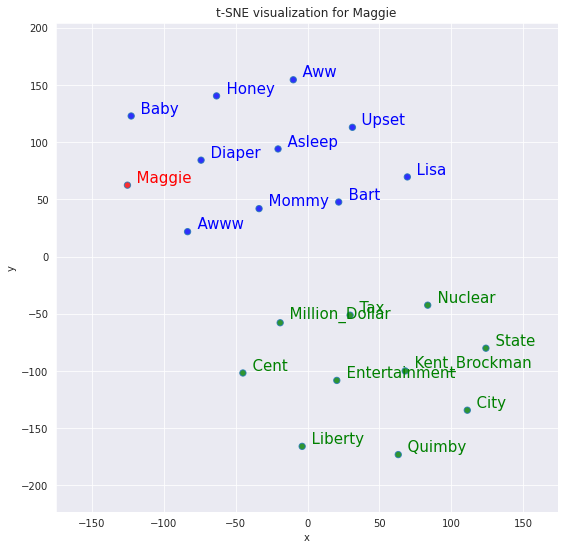

In [47]:
#-----------------------Parameters------------------------
word_ = 'maggie'
top_ = 10
embedding_size_ = 300
n_components_ = 20

#--------------Get similar and disimilar words------------
similar_words_ = get_top_n_similar_words(w2v_model, 'maggie', top_)
disimilar_words_ = get_top_n_disimilar_words(w2v_model, word_, top_)

#---------------------------Get data from tSNE------------------------------
data, labels, colors = tsne_generation(w2v_model, word_, n_components_, similar_words_, disimilar_words_, embedding_size_)
plot_tsne(data, word_, labels, colors)